# load dataset list

In [1]:
# running on adp env atm - switch to cellpose_pymat when built
import pandas as pd
import numpy as np
import scipy.io as sio

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['axes.titlesize'] = 5

from cellpose import utils, io, models
import os
import time
from IPython.display import clear_output

C:\Users\GlickfeldLab\anaconda3\envs\cellpose\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def show_segmentation_LL(fig, img, maski, flowi, channels=[0,0], file_name=None):
    """ plot segmentation results (like on website)
    
    Can save each panel of figure with file_name option. Use channels option if
    img input is not an RGB image with 3 channels.
    LL: changed subplot arrangement for wide subplots. turned off saving
    
    Parameters
    -------------

    fig: matplotlib.pyplot.figure
        figure in which to make plot

    img: 2D or 3D array
        image input into cellpose

    maski: int, 2D array
        for image k, masks[k] output from Cellpose.eval, where 0=NO masks; 1,2,...=mask labels

    flowi: int, 2D array 
        for image k, flows[k][0] output from Cellpose.eval (RGB of flows)

    channels: list of int (optional, default [0,0])
        channels used to run Cellpose, no need to use if image is RGB

    file_name: str (optional, default None)
        file name of image, if file_name is not None, figure panels are saved
        
    seg_norm: bool (optional, default False)
        improve cell visibility under labels
        

    """
    from cellpose.plot import image_to_rgb, mask_overlay

    ax = fig.add_subplot(4,1,1)
    img0 = img.copy()

    if img0.shape[0] < 4:
        img0 = np.transpose(img0, (1,2,0))
    if img0.shape[-1] < 3 or img0.ndim < 3:
        img0 = image_to_rgb(img0, channels=channels)
    else:
        if img0.max()<=50.0:
            img0 = np.uint8(np.clip(img0*255, 0, 1))
    ax.imshow(img0)
    ax.set_title('original image: stim resp dfof, gaussian filtered')
    ax.axis('off')

    outlines = utils.masks_to_outlines(maski)

    overlay = mask_overlay(img0, maski)

    ax = fig.add_subplot(4,1,2)
    outX, outY = np.nonzero(outlines)
    imgout= img0.copy()
    imgout[outX, outY] = np.array([255,0,0]) # pure red

    ax.imshow(imgout)
    ax.set_title('predicted outlines')
    ax.axis('off')

    ax = fig.add_subplot(4,1,3)
    ax.imshow(overlay)
    ax.set_title('predicted masks')
    ax.axis('off')

    ax = fig.add_subplot(4,1,4)
    ax.imshow(flowi)
    ax.set_title('predicted cell pose')
    ax.axis('off')

    # if file_name is not None:
    #     save_path = os.path.splitext(file_name)[0]
    #     io.imsave(save_path + '_overlay.jpg', overlay)
    #     io.imsave(save_path + '_outlines.jpg', imgout)
    #     io.imsave(save_path + '_flows.jpg', flowi)

In [3]:
dir_inter = r'C:\Users\GlickfeldLab\Documents\test\inter'.replace('\\', '/')
dir_file = dir_inter + '/data/adp_dataset_master.xlsx'
data_info = pd.read_excel(dir_file, sheet_name='Sheet1')
# data_info.sample(5)

In [4]:
# look for bunny 6s V1 datasets
df_bun = data_info[(data_info['paradigm'].str.contains('bunny')) & (data_info['gcamp'] == '6s') & (data_info['area'] == 'V1')]
df_bun = df_bun.drop_duplicates(subset='date', keep="first") # drop subseq sessions on same day. TODO: concat sess & motion correct
# df_bun = df_bun.sort_values('num', ascending=True).drop_duplicates('date').sort_index() # alt solution
df_bun = df_bun.reset_index(drop=True)
df_bun

,mouse,date,area,depth,num,manual_seg,paradigm,gcamp,AWS
0,1338,210616,V1,200,2.0,NaN,bunny6,6s,NaN
1,1339,210922,V1,200,2.0,NaN,bunny500,6s,NaN
2,1350,211222,V1,200,2.0,NaN,bunnytop,6s,NaN
3,1350,220225,V1,200,2.0,NaN,bunnytop high res,6s,NaN
4,1369,220310,V1,200,2.0,NaN,bunnytop high res,6s,NaN
5,1372,220406,V1,200,2.0,NaN,bunnytop high res high lum-contrast,6s,NaN


In [5]:
# look for grating 6s V1 datasets
df_grat = data_info[(data_info['paradigm'] == 'grating') & (data_info['gcamp'] == '6s') & (data_info['area'] == 'V1')]
df_grat = df_grat.reset_index(drop=True)
df_grat

,mouse,date,area,depth,num,manual_seg,paradigm,gcamp,AWS
0,1322,200803,V1,200,2.0,1.0,grating,6s,NaN
1,1323,200720,V1,200,3.0,1.0,grating,6s,1.0
2,1324,200728,V1,200,3.0,1.0,grating,6s,NaN
3,1328,201015,V1,200,4.0,1.0,grating,6s,1.0
4,1329,201209,V1,200,2.0,1.0,grating,6s,NaN
5,1337,210120,V1,200,2.0,NaN,grating,6s,NaN
6,1337,210120,V1,150,3.0,NaN,grating,6s,NaN
7,1338,210208,V1,200,2.0,NaN,grating,6s,NaN
8,1338,210208,V1,150,3.0,NaN,grating,6s,NaN
9,1338,210225,V1,200,2.0,NaN,grating,6s,NaN


## write into csv

In [5]:
df_bun['stim_type'] = 'bunny'
df_grat['stim_type'] = 'grating'

In [11]:
df = pd.concat([df_bun, df_grat])
df = df.reset_index(drop=True)
df.drop(columns=['AWS', 'manual_seg'], inplace=True)
# df.to_csv(dir_inter + '/data/batch_cellpose.csv', index=False)
df

,mouse,date,area,depth,num,paradigm,gcamp,stim_type
0,1338,210616,V1,200,2.0,bunny6,6s,bunny
1,1339,210922,V1,200,2.0,bunny500,6s,bunny
2,1350,211222,V1,200,2.0,bunnytop,6s,bunny
3,1350,220225,V1,200,2.0,bunnytop high res,6s,bunny
4,1369,220310,V1,200,2.0,bunnytop high res,6s,bunny
5,1372,220406,V1,200,2.0,bunnytop high res high lum-contrast,6s,bunny
6,1322,200803,V1,200,2.0,grating,6s,grating
7,1323,200720,V1,200,3.0,grating,6s,grating
8,1324,200728,V1,200,3.0,grating,6s,grating
9,1328,201015,V1,200,4.0,grating,6s,grating


# pymatbridge fails silently
TODO: fix logging

In [5]:
# from pymatbridge import Matlab
# mlab = Matlab(log=True)
# mlab.start()

Starting MATLAB on ZMQ socket tcp://127.0.0.1:63885
Send 'exit' command to kill the server
.............MATLAB started and connected!


In [6]:
# dir_func = r'C:\Users\GlickfeldLab\Documents\test\inter\scripts\adp_function\get_data_reg_cellpose_tif.m'.replace('\\', '/')
# res = mlab.run_func(dir_func, {'arg_mouse': df_bun.iloc[0].mouse, 'arg_date': df_bun.iloc[0].date})
# # print(res['result'].shape)
# res

In [27]:
# mlab.stop()

MATLAB closed


True

# sleep until cellpose tif is generated

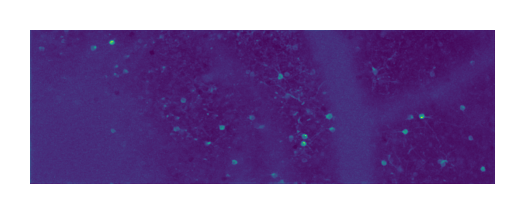

77


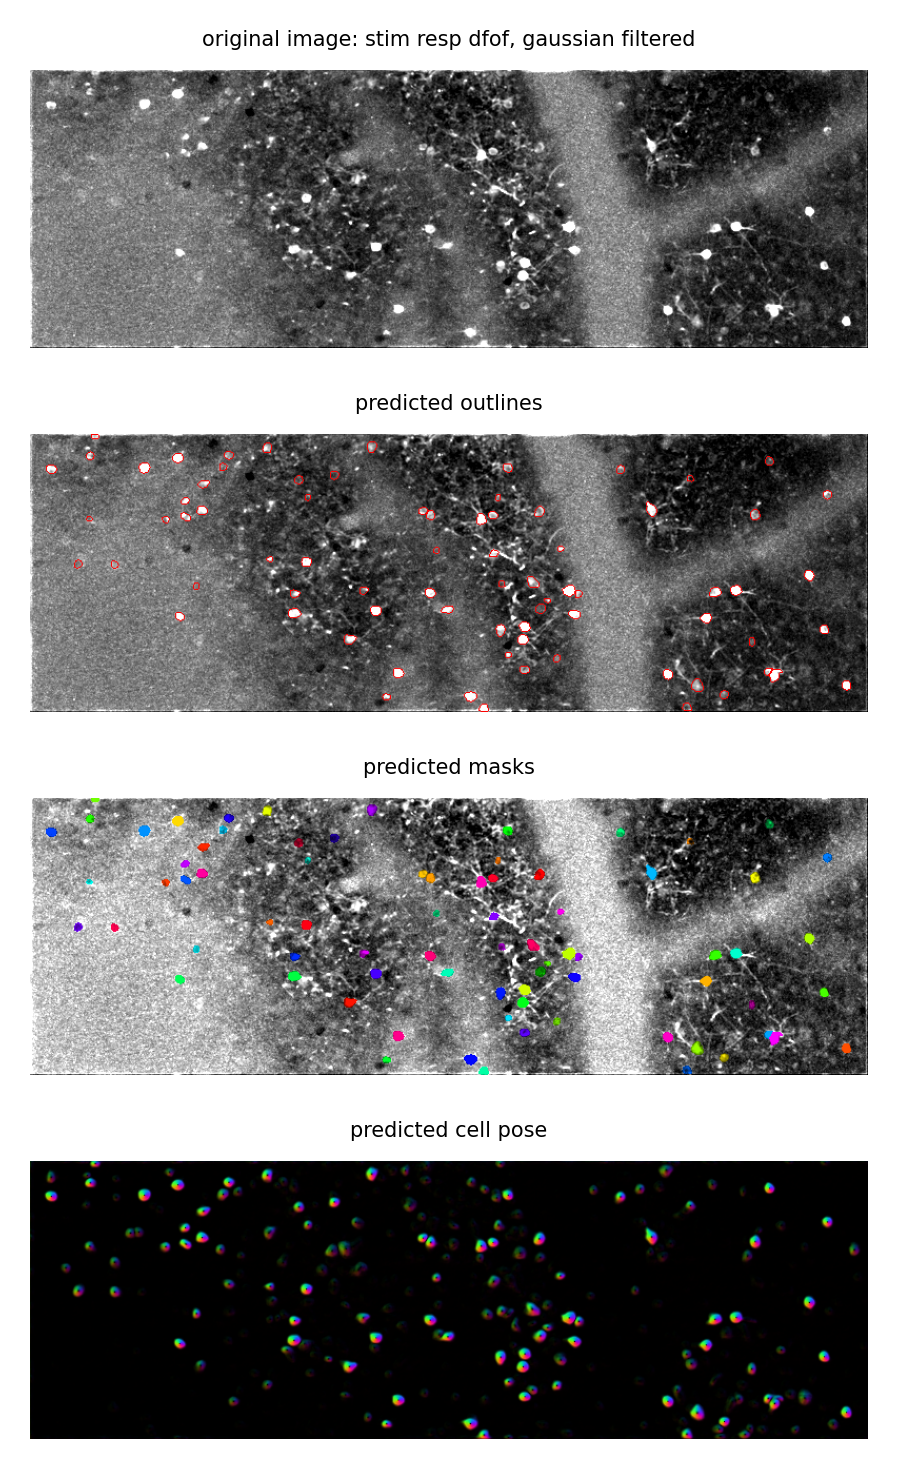

manual segmentation exists, now compare with cellpose


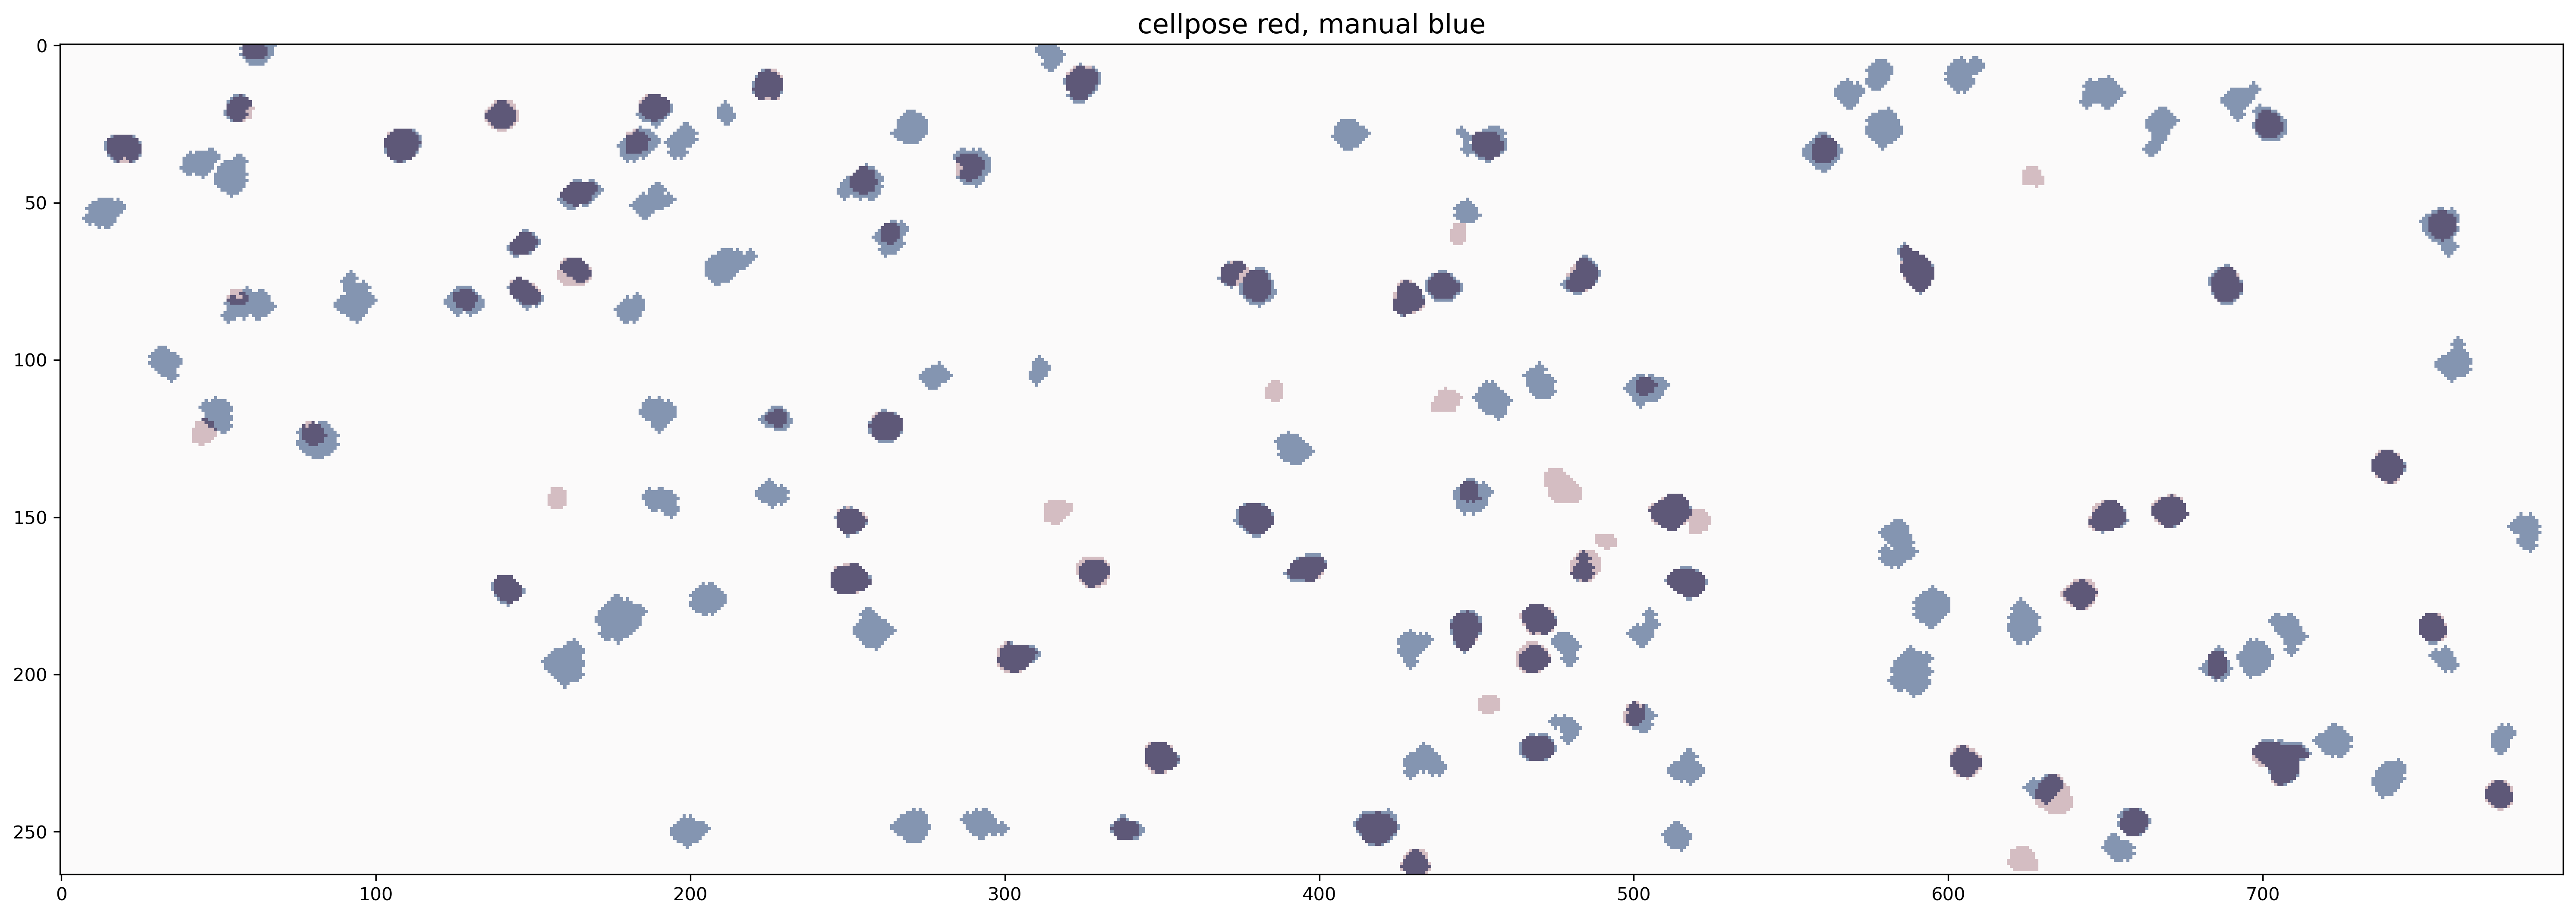

In [7]:
nset = df_bun.shape[0] # cellpose segment bunny dataset first

for i in np.arange(nset):
    print('iset =', i+1, 'of', df_bun.shape[0])
    mouse = df_bun.iloc[i].mouse.astype(str)
    imouse = 'i' + mouse
    date = df_bun.iloc[i].date.astype(str)
    irun = '00' + df_bun.iloc[i].num.astype(int).astype(str)
    print(imouse, date, irun)

    #####################################
    ## go to analysis directory
    dir_analysis = r'Z:\All_Staff\home\lan\Analysis\2P'.replace('\\', '/')
    date_imouse = date + '_' + imouse
    dir_run = date_imouse + '_runs-' + irun
    dir_full = os.path.join(dir_analysis, date_imouse, dir_run).replace('\\', '/')
    try:
        os.chdir(dir_full)
    except:
        print('directory not found, creating...')
        os.mkdir(dir_full)

    ## check if cellpose time course exists
    cellpose_done = False
    for filename in os.listdir(dir_full):
        if 'TCs_cellpose.mat' in filename:
            cellpose_done = True
    if cellpose_done and i!=0: # redo first bunny dataset
        print('cellpose time course exists, skip to next set')
        continue

    ## load tif after waiting
    files = ['cellpose_stim_resp_gauss.tif']
    while True:
        try:
            img = io.imread(files[0])
            break
        except:
            print(i+1, nset, imouse, date, irun)
            print('waiting for tif')
            time.sleep(60)
            clear_output(wait=True)

    img = io.imread(files[-1])
    assert img.shape == (264, 796) # confirm image shape: 30 frame/sec

    plt.figure(figsize=(2,2))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    # plt.savefig(dir_full + '/' + files[-1].replace('.tif', '.png'))

    #####################################
    ## run cellpose
    model = models.Cellpose(gpu=True, model_type='cyto') # enabled gpu
    channels = [[0,0]] # must be a list of lists for multiple images
    diameter = 20 # can be a list for multiple images
    flow_threshold = 0.4 # reset to default. previously -1
    cellprob_threshold = 0.0 # reset to default. previously -1

    for chan, filename in zip(channels, files):
        img = io.imread(filename)
        masks, flows, styles, diams = model.eval(img, diameter=None, channels=chan, flow_threshold=flow_threshold, cellprob_threshold=cellprob_threshold)
        io.masks_flows_to_seg(img, masks, flows, diams, filename, chan) # save npy
    ncell = np.max(np.unique(masks)) # check the number of cells
    print(ncell)

    fig = plt.figure(figsize=(12,5))
    show_segmentation_LL(fig, img, masks, flows[0], channels=chan)
    plt.tight_layout()
    plt.show()
    fig.savefig("cellpose_mask.pdf", bbox_inches='tight') # handle is fig

    #####################################
    ## check if manual segmentation exists
    manual_done = False
    for filename in os.listdir(dir_full):
        if 'TCs_addfake.mat' in filename:
            print('manual segmentation exists, now compare with cellpose')
            manual_done = True
    
    ## compare cellpose with manual segmentation
    if manual_done:
        assert masks.shape == (264, 796)
        sio.savemat('cellpose_mask.mat', mdict={'cellpose_mask': masks}) # save cellpose mask to mat # TODO: save to mapped drive

        # file_name = os.path.join(dir_analysis, date_imouse, dir_run, date_imouse + '_runs' + irun + '_mask_cell_addfake.mat')
        file_name = date_imouse + '_runs-' + irun + '_mask_cell_addfake.mat'
        manual_mask = sio.loadmat(file_name)
        manual_mask = manual_mask['mask_cell']
        assert manual_mask.shape == (264, 796)

        cellpose_mask_binary = masks.copy()
        cellpose_mask_binary[cellpose_mask_binary > 0] = 1
        manual_mask_binary = manual_mask.copy()
        manual_mask_binary[manual_mask_binary > 0] = 1

        plt.figure(figsize=(20, 10))
        plt.imshow(cellpose_mask_binary, cmap='Reds', alpha=0.5)
        plt.imshow(manual_mask_binary, cmap='Blues', alpha=0.5)
        plt.title('cellpose red, manual blue', fontsize=15)
        plt.tight_layout()
        plt.savefig("cellpose_compare_manual_mask.pdf", bbox_inches='tight')